In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [4]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

In [5]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

train_dataset = dsbuild('/home/de/lab/ds/corel5k', transform=transform)


In [6]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)

/tmp/ipykernel_90722/277675855.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
/tmp/ipykernel_90722/277675855.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]


4000

In [7]:
res = {}
res['p-tsne'] = []
res['p-umap'] = []

**FOLD 1**

**P-TSNE**

Training on cuda


100%|██████████| 8/8 [00:00<00:00, 37.84it/s]

====> Epoch: 1. Time 0:00:00.212405. Average loss: 10.3963



100%|██████████| 8/8 [00:00<00:00, 38.72it/s]

====> Epoch: 2. Time 0:00:00.207202. Average loss: 0.9797



100%|██████████| 8/8 [00:00<00:00, 38.21it/s]

====> Epoch: 3. Time 0:00:00.209885. Average loss: 0.6453



100%|██████████| 8/8 [00:00<00:00, 14.78it/s]

====> Epoch: 4. Time 0:00:00.541929. Average loss: 0.4798



100%|██████████| 8/8 [00:00<00:00, 14.74it/s]

====> Epoch: 5. Time 0:00:00.543503. Average loss: 0.3791



100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

====> Epoch: 6. Time 0:00:00.475247. Average loss: 0.3130



100%|██████████| 8/8 [00:00<00:00, 15.02it/s]

====> Epoch: 7. Time 0:00:00.533271. Average loss: 0.2680



100%|██████████| 8/8 [00:00<00:00, 14.82it/s]

====> Epoch: 8. Time 0:00:00.540436. Average loss: 0.2326



100%|██████████| 8/8 [00:00<00:00, 14.71it/s]

====> Epoch: 9. Time 0:00:00.544344. Average loss: 0.2062



100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

====> Epoch: 10. Time 0:00:00.481342. Average loss: 0.1835
Training time: 0:00:04.291108



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


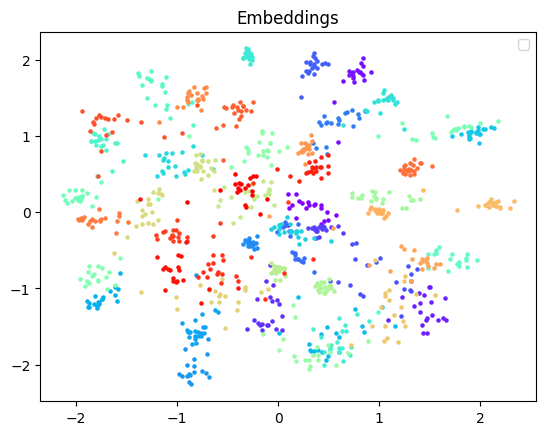

0.7027296666104412

In [8]:
from torch.utils.data import TensorDataset
from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

plotsmart(np.array(fs), lbs, "Embeddings", True)

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

**P-UMAP**

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 19:14:20 2024 Building RP forest with 8 trees
Mon Dec 16 19:14:21 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider incre

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([1000, 3072]) to (1000, 2)


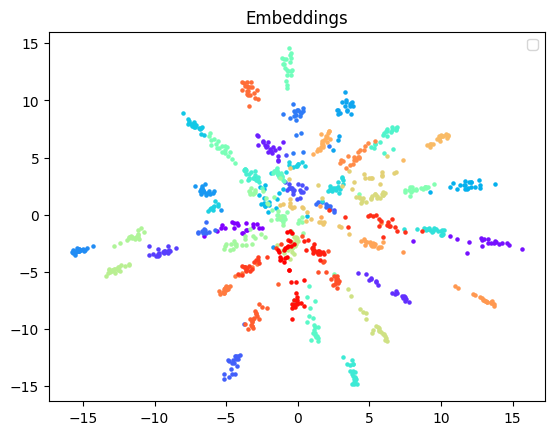

0.7811039688222884

In [9]:
import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))
plotsmart(embedding, lbs, "Embeddings", True)

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

**FOLD 2**

In [10]:
idfold = 1 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap


# ===============================================================================================
#                    P-UMAP
# ===============================================================================================



import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_90722/2137468460.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_90722/2137468460.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 38.26it/s]

====> Epoch: 1. Time 0:00:00.210122. Average loss: 10.2072



100%|██████████| 8/8 [00:00<00:00, 37.21it/s]

====> Epoch: 2. Time 0:00:00.215653. Average loss: 0.9732



100%|██████████| 8/8 [00:00<00:00, 38.26it/s]

====> Epoch: 3. Time 0:00:00.209634. Average loss: 0.6418



100%|██████████| 8/8 [00:00<00:00, 19.36it/s]

====> Epoch: 4. Time 0:00:00.413907. Average loss: 0.4779



100%|██████████| 8/8 [00:00<00:00, 14.59it/s]

====> Epoch: 5. Time 0:00:00.549094. Average loss: 0.3775



100%|██████████| 8/8 [00:00<00:00, 15.17it/s]

====> Epoch: 6. Time 0:00:00.528179. Average loss: 0.3135



100%|██████████| 8/8 [00:00<00:00, 16.59it/s]

====> Epoch: 7. Time 0:00:00.482787. Average loss: 0.2664



100%|██████████| 8/8 [00:00<00:00, 14.67it/s]

====> Epoch: 8. Time 0:00:00.545909. Average loss: 0.2303



100%|██████████| 8/8 [00:00<00:00, 15.36it/s]

====> Epoch: 9. Time 0:00:00.521549. Average loss: 0.2056



100%|██████████| 8/8 [00:00<00:00, 14.73it/s]

====> Epoch: 10. Time 0:00:00.543750. Average loss: 0.1831
Training time: 0:00:04.222187



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 19:15:48 2024 Building RP forest with 8 trees
Mon Dec 16 19:15:48 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 3072]) to (1000, 2)


0.8072652214446976

**FOLD 3**

In [11]:
idfold = 2 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap


# ===============================================================================================
#                    P-UMAP
# ===============================================================================================



import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_90722/1903354167.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_90722/1903354167.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 38.24it/s]

====> Epoch: 1. Time 0:00:00.210030. Average loss: 10.4059



100%|██████████| 8/8 [00:00<00:00, 38.48it/s]

====> Epoch: 2. Time 0:00:00.208525. Average loss: 0.9664



100%|██████████| 8/8 [00:00<00:00, 38.50it/s]

====> Epoch: 3. Time 0:00:00.208377. Average loss: 0.6383



100%|██████████| 8/8 [00:00<00:00, 38.22it/s]

====> Epoch: 4. Time 0:00:00.209875. Average loss: 0.4733



100%|██████████| 8/8 [00:00<00:00, 38.42it/s]

====> Epoch: 5. Time 0:00:00.208842. Average loss: 0.3784



100%|██████████| 8/8 [00:00<00:00, 38.59it/s]

====> Epoch: 6. Time 0:00:00.207859. Average loss: 0.3120



100%|██████████| 8/8 [00:00<00:00, 38.46it/s]

====> Epoch: 7. Time 0:00:00.208583. Average loss: 0.2656



100%|██████████| 8/8 [00:00<00:00, 38.41it/s]

====> Epoch: 8. Time 0:00:00.208866. Average loss: 0.2325



100%|██████████| 8/8 [00:00<00:00, 27.49it/s]

====> Epoch: 9. Time 0:00:00.291707. Average loss: 0.2055



100%|██████████| 8/8 [00:00<00:00, 18.06it/s]

====> Epoch: 10. Time 0:00:00.443599. Average loss: 0.1834
Training time: 0:00:02.407729



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 19:17:08 2024 Building RP forest with 8 trees
Mon Dec 16 19:17:08 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 3072]) to (1000, 2)


0.7849810192893556

**FOLD 4**

In [12]:
idfold = 3 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

# ===============================================================================================
#                    P-UMAP
# ===============================================================================================

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_90722/1464832672.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_90722/1464832672.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 38.21it/s]

====> Epoch: 1. Time 0:00:00.210170. Average loss: 10.3702



100%|██████████| 8/8 [00:00<00:00, 24.00it/s]

====> Epoch: 2. Time 0:00:00.333948. Average loss: 0.9651



100%|██████████| 8/8 [00:00<00:00, 14.71it/s]

====> Epoch: 3. Time 0:00:00.544468. Average loss: 0.6380



100%|██████████| 8/8 [00:00<00:00, 15.59it/s]

====> Epoch: 4. Time 0:00:00.513854. Average loss: 0.4718



100%|██████████| 8/8 [00:00<00:00, 15.04it/s]

====> Epoch: 5. Time 0:00:00.532708. Average loss: 0.3799



100%|██████████| 8/8 [00:00<00:00, 29.80it/s]

====> Epoch: 6. Time 0:00:00.269435. Average loss: 0.3130



100%|██████████| 8/8 [00:00<00:00, 38.57it/s]

====> Epoch: 7. Time 0:00:00.208038. Average loss: 0.2681



100%|██████████| 8/8 [00:00<00:00, 38.40it/s]

====> Epoch: 8. Time 0:00:00.208832. Average loss: 0.2324



100%|██████████| 8/8 [00:00<00:00, 33.15it/s]

====> Epoch: 9. Time 0:00:00.241969. Average loss: 0.2054



100%|██████████| 8/8 [00:00<00:00, 16.20it/s]

====> Epoch: 10. Time 0:00:00.494656. Average loss: 0.1829
Training time: 0:00:03.559772



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 19:18:30 2024 Building RP forest with 8 trees
Mon Dec 16 19:18:30 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 3072]) to (1000, 2)


0.7811960437027391

**FOLD 5**

In [13]:
idfold = 4 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

# ===============================================================================================
#                    P-UMAP
# ===============================================================================================

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_90722/897998413.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_90722/897998413.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 15.84it/s]

====> Epoch: 1. Time 0:00:00.505909. Average loss: 10.3392



100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

====> Epoch: 2. Time 0:00:00.476727. Average loss: 0.9831



100%|██████████| 8/8 [00:00<00:00, 14.65it/s]

====> Epoch: 3. Time 0:00:00.546831. Average loss: 0.6457



100%|██████████| 8/8 [00:00<00:00, 14.99it/s]

====> Epoch: 4. Time 0:00:00.534502. Average loss: 0.4788



100%|██████████| 8/8 [00:00<00:00, 18.96it/s]

====> Epoch: 5. Time 0:00:00.422551. Average loss: 0.3797



100%|██████████| 8/8 [00:00<00:00, 14.67it/s]

====> Epoch: 6. Time 0:00:00.545865. Average loss: 0.3152



100%|██████████| 8/8 [00:00<00:00, 15.42it/s]

====> Epoch: 7. Time 0:00:00.519359. Average loss: 0.2677



100%|██████████| 8/8 [00:00<00:00, 18.21it/s]

====> Epoch: 8. Time 0:00:00.440075. Average loss: 0.2324



100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

====> Epoch: 9. Time 0:00:00.508923. Average loss: 0.2046



100%|██████████| 8/8 [00:00<00:00, 20.91it/s]

====> Epoch: 10. Time 0:00:00.383357. Average loss: 0.1835
Training time: 0:00:04.885956



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 19:19:53 2024 Building RP forest with 8 trees
Mon Dec 16 19:19:53 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 3072]) to (1000, 2)


0.799741916521794

**Resultados**

In [14]:
res

{'p-tsne': [0.7027296666104412,
  0.7196101323592725,
  0.7286722314333469,
  0.6952783730667307,
  0.7188504824005804],
 'p-umap': [0.7811039688222884,
  0.8072652214446976,
  0.7849810192893556,
  0.7811960437027391,
  0.799741916521794]}

In [15]:
[{r: np.mean(res[r]) } for r in res]

[{'p-tsne': 0.7130281771740744}, {'p-umap': 0.7908576339561749}]